# Blogpost Article Generator - Transformer GPT-2
Author: Amelia Budiharto, Mark Cannel, Pascal Waser, Quyen Duong

## 1. Background Information
This notebook presents the code of text genetator for a blogpost article. The model trained using a article text under the category of technology. We used pre-trained transformer model (+1.5 billions datapoints). As a result, it aims to generate the next sequence of words based on the input keyword that we give in the beginning by fine-tuning GPT-2 model.

## 1. Preparation

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel

In [ ]:
# Set seed for reproducability purpose

torch.manual_seed(1)

In [ ]:
# Check whether the CUDA driver is available or not

torch.cuda.is_available()

True

## 2. Load Pre-trained Model and Training Dataset
There are several GPT2 module. In this case, we use the generic GPT2 module.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = GPT2LMHeadModel.from_pretrained('gpt2').cuda()
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Embedding(50259, 768)

Import the clean dataset that already transformed on the 'TextGenerator_Bidirectional_RNN_WordSequence' notebook 

In [75]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data

/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data


In [ ]:
# Load clean text to avoid running above codes

my_file = open("/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Data/clean_text_tech_news.txt", "r")
content = my_file.read()

corpus = content.split(",")
my_file.close()

In [ ]:
# Transform the dataset into pandas series

descriptions = pd.Series(corpus)

type(descriptions)

In [ ]:
descriptions

0          madden espn football score in different way ...
1        group to propose new high speed wireless forma...
2        aol to sell cheap pcs to minority and senior a...
3        company approve new high capacity disc format ...
4        miss june deal slow to return for software cos...
                               ...                        
29996    digitize and bring to life digital technology ...
29997    new computer six step to safe surfing to see t...
29998    video file present search challenge indexing w...
29999    compromise seal climate meeting climate confer...
30000                                                     
Length: 30001, dtype: object

## 3. Prepare Input Features for fine-tuning GPT-2 Model

In [ ]:
# Tokenize the sentence

max_length = max([len(tokenizer.encode(description)) for description in descriptions])

class NewsDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', truncation=True,
                                       max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
# Split dataset

dataset = NewsDataset(descriptions, tokenizer, max_length=max_length)
train_size = int(0.9 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

In [ ]:
# Collect the garbage to empty the cuda cache

import gc
gc.collect()

149

In [ ]:
# Empty the cuda cache

torch.cuda.empty_cache()

## 4. Train Model

In [ ]:
training_args = TrainingArguments(output_dir='/content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults', num_train_epochs=1, logging_steps=100, save_steps=5000,
                                  per_device_train_batch_size=1, per_device_eval_batch_size=1,
                                  warmup_steps=10, weight_decay=0.05, logging_dir='/content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/logs', report_to = 'none')

In [ ]:
Trainer(model=model, args=training_args, train_dataset=train_dataset, 
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])}).train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 27000
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 27000


Step,Training Loss
100,3.074100
200,1.192800
300,1.170700
400,1.123100
500,1.083000
600,1.001100
700,1.015100
800,1.031800
900,1.020800
1000,0.954800


Saving model checkpoint to /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-5000
Configuration saved in /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-5000/config.json
Model weights saved in /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-10000
Configuration saved in /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-10000/config.json
Model weights saved in /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-15000
Configuration saved in /content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/checkpoint-15000/config.json
Model weights saved in /content/drive/M

TrainOutput(global_step=27000, training_loss=0.8708230763188115, metrics={'train_runtime': 3195.1037, 'train_samples_per_second': 8.45, 'train_steps_per_second': 8.45, 'total_flos': 2797151616000000.0, 'train_loss': 0.8708230763188115, 'epoch': 1.0})

In [ ]:
# Save the fine-tune model

torch.save(model, '/content/drive/My Drive/Colab Notebooks/DeepLearningVision/GPTresults/model')

## 5. Generate Text
There are different decoding methods for language generation with Transformers. We will compare 4 different decoding approachs using the fine-tune GPT-2 model. The decoding methods adapted from https://colab.research.google.com/github/huggingface/blog/blob/main/notebooks/02_how_to_generate.ipynb#scrollTo=Y77H5m4ZmhEX

In [ ]:
generated = tokenizer("Internet explorer ", return_tensors="pt").input_ids.cuda()
generated

### Greedy Search Approach
Greedy search simply selects the word with the highest probability as its next word at each timestep.

![Greedy Search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/greedy_search.png)


In greedy search we just try to predict the next words without any other parameter to consider. As a result, it would creates quite random word sequence in a sentence.

In [ ]:
greedy_outpus = model.generate(generated, do_sample=True, 
                                max_length=330, num_return_sequences=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for i, output in enumerate(greedy_outpus):
    print("{}: {}".format(i, tokenizer.decode(output, skip_special_tokens=True)))

0: Internet explorer ipsi to deliver content ad free software from ipsi be get their start with the release of one of the favorite advertising tool adobe systems corp lt href http www co uk financequotelookup jhtml ticker adaplz qtype sym infotype info qcat news gt adai lt gt aim to replace the internet advertising


### Beam Search Approach
Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely `num_beams` of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Let's illustrate with `num_beams=2`:

![Beam search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/beam_search.png)

We use the optimum number of beam with size of 6 and to avoid redudant word sequence we limit it through n_gram with size of 2. The number of beam used to define how big the branches of the sequence of the next predicted word. The bigger the size, more word options will be appeared. However, it does not mean that higher beam size can gives better result, as it is will make more random sentence which cause the sentence loose the meaning and context.

In [ ]:
beam_outpus = model.generate(generated, do_sample=True, 
                                max_length=330, num_beams=6, no_repeat_ngram_size=2, num_return_sequences=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for i, output in enumerate(beam_outpus):
    print("{}: {}".format(i, tokenizer.decode(output, skip_special_tokens=True)))

0: Internet explorer ietf warn of security flaw in windows xp service pack microsoft on tuesday warn that security hole could allow an attacker to take control of user computer and steal their personal information


### Top-K Sampling Approach
In *Top-K* sampling, the *K* most likely next words are filtered and the probability mass is redistributed among only those *K* next words. 
GPT2 adopted this sampling scheme, which was one of the reasons for its success in story generation. 

In here, we select the top 25 words that most likely appears following the token word.

In [ ]:
topk_outputs = model.generate(generated, do_sample=True, top_k=25, 
                                max_length=330, temperature=0.5, num_return_sequences=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for i, output in enumerate(topk_outputs):
    print("{}: {}".format(i, tokenizer.decode(output, skip_special_tokens=True)))

0: Internet explorer ix to be launch next week in the late round of the open source enterprise linux series the xm release be expect to be available on the next os and will be available for download in the next few day


### Top-p (nucleus) Sampling Approach
Instead of sampling only from the most likely *K* words, in *Top-p* sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability *p*.

In here, we can take a bigger size of top-k sampling because we will give penalty using top-p probability. It means that a word will not be selected or consider if the probability of two words appear together below 95%.

In [ ]:
nucleus_outputs = model.generate(generated, do_sample=True, top_k=100, 
                                max_length=330, top_p=0.95, temperature=0.5, num_return_sequences=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for i, output in enumerate(nucleus_outputs):
    print("{}: {}".format(i, tokenizer.decode(output, skip_special_tokens=True)))

0: Internet explorer ietf say it have develop new web browser that will help user find and download file on their hard drive


## Conclusion
As a conclusion, each decoding methods have it flaws. The top-K and top-p sampling is a good approach to avoid repetitive word sequences. In addition, the top-p approach able to generate more fluid sentence compare to top-K sampling. However, according to other researcher, if we have more domain specific text, beam search could be a better choice since it could limit the choice of word options to generate the next word from our token.

As model comparison with RNN, the pre-trained model surely able to generate better sentence since it is include more vocabulary in the initial trained model. Therefore, fine-tune a pre-trained model can be an alternative option if we do not need to generate a domain specific text.

## Appendix

In [82]:
%cd /content/drive/My Drive/Colab Notebooks/DeepLearningVision/Train Model

/content/drive/My Drive/Colab Notebooks/DeepLearningVision/Train Model


In [83]:
import pandas as pd
  
# read text file into pandas DataFrame
training_loss = pd.read_csv("GPT2_loss.txt", sep="\t")
  
# display DataFrame
print(training_loss)

      Step  Training Loss
0      100         3.0741
1      200         1.1928
2      300         1.1707
3      400         1.1231
4      500         1.0830
..     ...            ...
265  26600         0.8220
266  26700         0.8456
267  26800         0.8167
268  26900         0.7846
269  27000         0.7540

[270 rows x 2 columns]


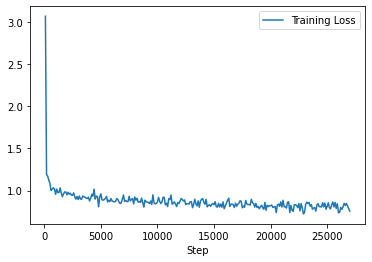

In [84]:
training_loss.plot.line(x='Step', y='Training Loss')